## ARCH Model Forecasting

**Functions**

`sm.OLS`, `sm.WLS`


### Exercise 77

Use 50% of the sample to estimate your preferred GARCH model for returns to the S&P 500 and the
EUR/USD rate, and construct forecasts for the remaining period.

Let's begin by loading the SP500 data:

In [1]:
import pandas as pd

In [2]:
sp500 = pd.read_hdf('./data/arch-data.h5','sp500')
returns = 1000 * sp500.pct_change().dropna()
returns

,SP500
DATE,
2011-02-15,-3.234959
2011-02-16,6.257483
2011-02-17,3.075611
2011-02-18,1.924755
2011-02-22,-20.528514
...,...
2019-12-24,-0.195409
2019-12-26,5.128157
2019-12-27,0.033952


In the previous class, we found that a **TARCH(1,1,1)** is the best model for the SP500 series. Now we re-estimate this model using the first half of the sample as the question asked:

In [3]:
from arch import arch_model

In [4]:
# Setting TARCH(1,1,1) for the return series as 'mod'
mod = arch_model(returns, o=1, power=1.0)

Differently to what we did in time series analysis (when we split the data before estimating parameters), we defined the model for the full sample. The reason for this is because `fit` method of the `arch_model` class has a `last_obs` feature (see [arch_model Doc](https://arch.readthedocs.io/en/latest/univariate/introduction.html)). This allows us to set the last observation we want to consider when estimating the model. Note that `last_obs` is not actually used in fitting, and only dates < `last_obs` are.

In [5]:
# Gettin the index of the half-point
half = returns.index[returns.shape[0] // 2]
# Fitting the model using the first half
res = mod.fit(last_obs=half, disp="off")

Let's check up to which point we have estimated variances and compare it with the half sample point.

In [6]:
is_variance = res.conditional_volatility**2
print(half)
is_variance.dropna().tail()
# We use dropna() because points after 'last_obs' values are set to na

2015-07-27 00:00:00


DATE
2015-07-20    37.602844
2015-07-21    32.382630
2015-07-22    40.972945
2015-07-23    42.953532
2015-07-24    56.131412
Name: cond_vol, dtype: float64

We can now use the model fitted saved in **res** to forecast. For such, we use the `forecast` method. Its documentation can be found here: [forecast Doc](https://arch.readthedocs.io/en/latest/univariate/generated/generated/arch.univariate.base.ARCHModelResult.forecast.html#arch.univariate.base.ARCHModelResult.forecast)

An importat input is `align`. The default option `align=origin` aligns forecasts to the last observation used in producing the forecast. We wish, however, to align forecasts to the observation index that is being forecasted. Hence we set `align=target`.

In [7]:
# Using our model to forecast
forecasts = res.forecast(align="target")
# Getting the forecasted variances
oos_variance = forecasts.variance.dropna()
# We use dropna() because points before 'last_obs' values are set to na
oos_variance

,h.1
DATE,
2015-07-27,90.891535
2015-07-28,101.709717
2015-07-29,82.778827
2015-07-30,68.022557
2015-07-31,57.051298
...,...
2019-12-24,15.461830
2019-12-26,15.116478
2019-12-27,14.107636


We can now finally plot the fitted and forecasted variances. 

In [10]:
# Importing the libraries we use for plotting
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# Setting the style and size of the plots
sns.set_style("darkgrid")
plt.rc("figure", figsize=(18, 6))
plt.rc("font", size=14)

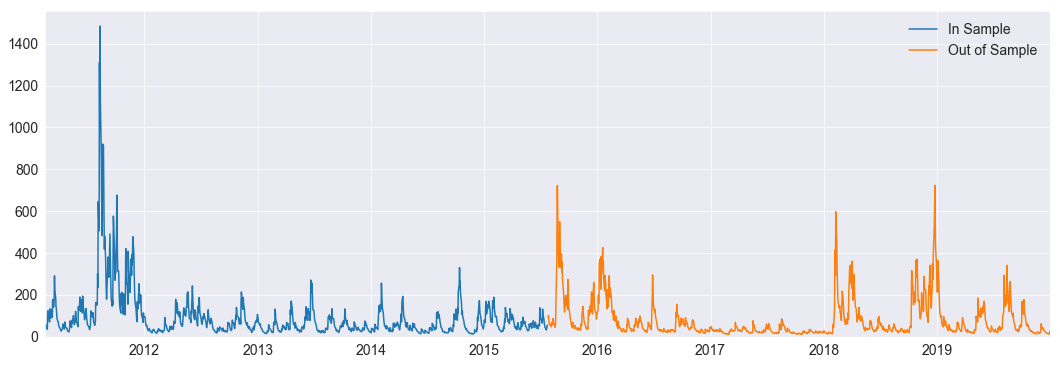

In [11]:
# Plotting variances
fig, ax = plt.subplots(1, 1)
plt.plot(is_variance, label="In Sample")
plt.plot(oos_variance, label="Out of Sample")
ax.set_xlim(is_variance.index[0], oos_variance.index[-1])
ylim = ax.set_ylim(0, ax.get_ylim()[1])
# The _ is used to capture the output from the legend command so that does not print
_ = plt.legend(frameon=False)

This is nice because it allows us to see the changes in second moments dynamics. But the scales don't allow us to draw much inference. Recall we multiplied the returns by 1000 (rather than 100) to get percentages because we wanted larger values to make our maximum likelihood estimation easier. We will transform the scale of the series to percentage returns and calculate annualized volatility in order to plot values that can be interpreted.

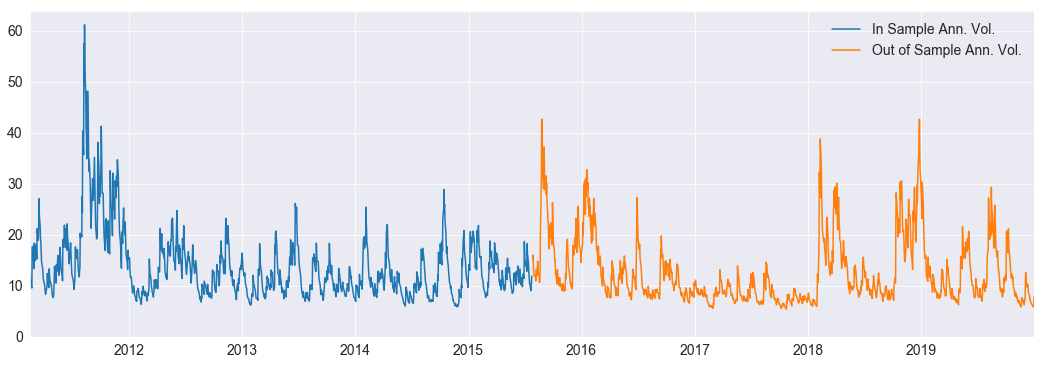

In [12]:
# Plotting annualized volatility
_, ax = plt.subplots(1, 1)
plt.plot(np.sqrt(252*is_variance / 100), label="In Sample Ann. Vol.")
plt.plot(np.sqrt(252*oos_variance / 100), label="Out of Sample Ann. Vol.")
ax.set_xlim(is_variance.index[0], oos_variance.index[-1])
ax.set_ylim(0, ax.get_ylim()[1])
_ = plt.legend(frameon=False)

### Exercise 78

Evaluate the accuracy of the forecasts.

Lets begin by concatenating returns and forecasted variance in one dataframe so it is easier to access them.

In [13]:
# Join the returns and the variance forecasts
combined = pd.concat([returns, oos_variance], axis = 1)
combined.columns = ["returns","oos_variance"]
# Remove missing
combined = combined.dropna() 

In previous classes, we saw how to perform the 'standard' MZ test in Python. We will now also see some different variants. Let's begin with the same we did in previous classes. 

In [14]:
# Importing statsmodels
import statsmodels.api as sm

In [15]:
# Construct the error
mu = res.params["mu"]
variance_error = (combined.returns - mu) ** 2 - combined.oos_variance

In [16]:
# Performing the 'standard' MZ Regression
x = sm.add_constant(combined.oos_variance)
res = sm.OLS(variance_error, x).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.825
Date:                Tue, 23 Feb 2021   Prob (F-statistic):             0.0931
Time:                        18:23:15   Log-Likelihood:                -7249.1
No. Observations:                1117   AIC:                         1.450e+04
Df Residuals:                    1115   BIC:                         1.451e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.9687      6.259      0.315      0.753     -10.313      14.250
oos_variance    -0.0872      0.052     -1.681      0.093      -0.189       0.015
==============================================================================
Omnibus:                     1136.287   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69428.342
Skew:                           4.773   Prob(JB):                         0.00
Kurtosis:                      40.425   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# Performing the 'standard' MZ test
r_matrix = np.eye(2)
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[1.92751695]]), p=0.14599360108844397, df_denom=1.12e+03, df_num=2>

In [18]:
# Now considering HAC standard errors
x = sm.add_constant(combined.oos_variance)
res = sm.OLS(variance_error, x).fit(cov_type="HC0")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                    0.2863
Date:                Tue, 23 Feb 2021   Prob (F-statistic):              0.593
Time:                        18:23:15   Log-Likelihood:                -7249.1
No. Observations:                1117   AIC:                         1.450e+04
Df Residuals:                    1115   BIC:                         1.451e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.9687     10.384      0.190      0.850     -18.383      22.321
oos_variance    -0.0872      0.163     -0.535      0.593      -0.406       0.232
==============================================================================
Omnibus:                     1136.287   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69428.342
Skew:                           4.773   Prob(JB):                         0.00
Kurtosis:                      40.425   Cond. No.                         158.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [19]:
# Performing the MZ test
r_matrix = np.eye(2)
res.wald_test(r_matrix)

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[1.05134962]], p-value=0.5911563104070479, df_denom=2>

In [20]:
# Performing the MZ test
r_matrix = np.eye(2)
res.wald_test(r_matrix, use_f=True)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.52567481]]), p=0.5913027446637883, df_denom=1.12e+03, df_num=2>

Finally, we can also use a weighted LS estimator where the variance is the inverse of the squared forecast. This creates the MZ-GLS test. In order to estimate this model, we use the `WLS` class from statsmodels. Its documentation can be found here: [WLS Doc](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.WLS.html).

In [21]:
# Estimating a GLS model
res = sm.WLS(variance_error, x, weights=1./(combined.oos_variance**2)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.06446
Date:                Tue, 23 Feb 2021   Prob (F-statistic):              0.800
Time:                        18:23:16   Log-Likelihood:                -6827.7
No. Observations:                1117   AIC:                         1.366e+04
Df Residuals:                    1115   BIC:                         1.367e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.4738      3.675     -0.129      0.897      -7.685       6.737
oos_variance    -0.0297      0.117     -0.254      0.800      -0.259       0.200
==============================================================================
Omnibus:                     1666.336   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           611728.454
Skew:                           8.647   Prob(JB):                         0.00
Kurtosis:                     116.334   Cond. No.                         56.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# Doing the test
test = res.wald_test(np.eye(2), use_f=False)
test

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.44459623]], p-value=0.8006766351562951, df_denom=2>

### Exercise 79

Evaluate the accuracy of forecasts from a 2-year backward moving average variance.

We are now asked to perform the same accuracy analysis we did for our model, but for a 2-year moving average model. Let's begin by building the forecasts from this 2-year moving avarage.

In [23]:
rolling_variance = (returns**2).rolling(2*252).mean()
rolling_variance = rolling_variance.shift(1)
rolling_variance.columns = ["rolling_variance"]
rolling_mean = returns.rolling(2*252).mean()
rolling_mean = rolling_mean.shift(1)
rolling_mean.columns = ["rolling_mean"]
# Add both series to our 'combined' dataframe
combined = pd.concat([combined, rolling_mean, rolling_variance], axis=1).dropna()

Now let's plot how this forecasts compare to the one from our model:

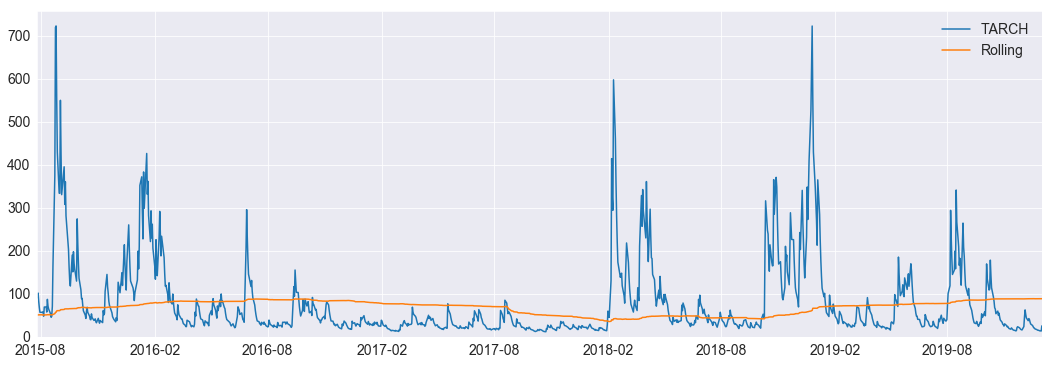

In [24]:
_, ax = plt.subplots(1, 1)
plt.plot(combined.oos_variance, label="TARCH")
plt.plot(combined.rolling_variance, label="Rolling")
ax.set_xlim(combined.index[0], combined.index[-1])
ax.set_ylim(0, ax.get_ylim()[1])
_ = plt.legend(frameon=False)

Now let's turn to what the question has asked and perform a MZ test in the forecasts of this 2-year rolling model.

In [25]:
# Constructing the error
eps = combined.returns - combined.rolling_mean
variance_error = eps ** 2 - combined.rolling_variance

The shocks are the returns minus the mean. The variance error is then the squared shock minus the variance. The MZ regression regresses the variance
error on a constant and the forecast. Both the constant and the forecast have coefficients that are statstically different from zero.

In [26]:
# Building the MZ regression
x = sm.add_constant(combined.rolling_variance)
res = sm.OLS(variance_error, x).fit(cov_type="HC0")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     33.83
Date:                Tue, 23 Feb 2021   Prob (F-statistic):           7.84e-09
Time:                        18:23:18   Log-Likelihood:                -7390.4
No. Observations:                1117   AIC:                         1.478e+04
Df Residuals:                    1115   BIC:                         1.479e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              154.2095     28.796      5.355      0.000      97.771     210.648
rolling_variance    -2.1847      0.376     -5.817      0.000      -2.921      -1.449
==============================================================================
Omnibus:                     1298.837   Durbin-Watson:                   1.450
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           116477.274
Skew:                           5.864   Prob(JB):                         0.00
Kurtosis:                      51.632   Cond. No.                         312.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [27]:
test = res.wald_test(np.eye(2), use_f=False)
test

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[39.61253335]], p-value=2.5017716987543697e-09, df_denom=2>

Unsurprisingly a strong rejection here. The results seem to suggest or TARCH model is much better.

### Exercise 80

Compare the ARCH-model forecasts to a naive 2-year backward looking moving average using QLIKE.

From the time series part of the course, remember that we used a Diebold-Mariano test to compare different models. In order to perform a DM Test, however, we need a penalty measure so we can test if this penalty is significantly different from one model to the other. Here, we will use QLIK loss as a measure of how bad a forecast is. 

The QLIK loss is defined as:

$$ \frac{\left(r_{t+1}-\hat{\mu}_{t+1}\right)}{\hat{\sigma}^2_{t+1}} + \ln{\hat{\sigma}^2_{t+1}}.$$


Lets begin by building the series of this loss for each of the models:

In [30]:
# Concatenating both forecasts in one dataframe
forecasts = combined[["oos_variance","rolling_variance"]]
# Getting the series of residuals
tarch_eps = combined.returns - mu
# Calculating QLIK for TARCH
tarch_forecast = combined.oos_variance
qlik_tarch = (tarch_eps**2)/tarch_forecast + np.log(tarch_forecast)
# Getting the series of residuals
rolling_eps = combined.returns - combined.rolling_mean
# Calculating QLIK for rolling mean
rolling_forecast = combined.rolling_variance
qlik_rolling = (rolling_eps**2)/rolling_forecast + np.log(rolling_forecast)

Performing the DM test on the loss difference between models.

In [31]:
# Calculating the loss difference
delta = qlik_tarch - qlik_rolling
# Performing the DM regression
lags = int(1.2 * delta.shape[0] ** (1/3))
dm = sm.OLS(delta, np.ones_like(delta)).fit(cov_type="HAC", cov_kwds={"maxlags":lags})
dm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 23 Feb 2021   Prob (F-statistic):                nan
Time:                        19:17:00   Log-Likelihood:                -2635.0
No. Observations:                1117   AIC:                             5272.
Df Residuals:                    1116   BIC:                             5277.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5317      0.106     -5.017      0.000      -0.739      -0.324
==============================================================================
Omnibus:                     1398.536   Durbin-Watson:                   1.690
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           353185.379
Skew:                          -6.222   Prob(JB):                         0.00
Kurtosis:                      89.219   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
"""

#### Explanation

The DM test is implemented as the difference between the losses. A Newey-West covariance
is required since we cannot beleive that both models are correctly specified.  Here I use
$1.2 \times T^{\frac{1}{3}}$ for simplicity. The statistic is computed by regressing
the difference on a constant and using a HAC covariance.

The results from the DM test confirm what we expected after evaluating model accuracy in the MZ framework. That is, the DM test has confirmed that our TARCH(1,1,1) model is significantly better than the rolling mean model.